In [81]:
from itertools import combinations
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import ttest_ind
from pandas._typing import FrameOrSeries

df = pd.read_csv('stud_math.csv')

pd.set_option('display.max_rows',50)
pd.set_option('display.max_columns',50)

#Описание датасета
# 1 school — аббревиатура школы, в которой учится ученик
# 2 sex — пол ученика ('F' - женский, 'M' - мужской)
# 3 age — возраст ученика (от 15 до 22)
# 4 address — тип адреса ученика ('U' - городской, 'R' - за городом)
# 5 famsize — размер семьи('LE3' <= 3, 'GT3' >3)
# 6 Pstatus — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)
# 7 Medu — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)
# 8 Fedu — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)
# 9 Mjob — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)
# 10 Fjob — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)
# 11 reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)
# 12 guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое)
# 13 traveltime — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)
# 14 studytime — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)
# 15 failures — количество внеучебных неудач (n, если 1<=n<=3, иначе 0)
# 16 schoolsup — дополнительная образовательная поддержка (yes или no)
# 17 famsup — семейная образовательная поддержка (yes или no)
# 18 paid — дополнительные платные занятия по математике (yes или no)
# 19 activities — дополнительные внеучебные занятия (yes или no)
# 20 nursery — посещал детский сад (yes или no)
# 21 higher — хочет получить высшее образование (yes или no)
# 22 internet — наличие интернета дома (yes или no)
# 23 romantic — в романтических отношениях (yes или no)
# 24 famrel — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)
# 25 freetime — свободное время после школы (от 1 - очень мало до 5 - очень мого)
# 26 goout — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)
# 27 health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)
# 28 absences — количество пропущенных занятий
# 29 score — баллы по госэкзамену по математике

In [82]:
#Добавим класс обертку, перегрузим, добавим новые методы
class DataFrame(pd.DataFrame):

    def describe(self: FrameOrSeries, percentiles=None, include=None, exclude=None) -> FrameOrSeries:

        description = super().describe(percentiles=percentiles,include=include,exclude=exclude)
        rows_count = len(self)

        def add_indicators(column):
            iqr = column['75%']-column['25%']
            bottom_bound = column['25%']-1.5*iqr
            top_bound = column['75%']+1.5*iqr

            description.loc['nan_count', column.name] = rows_count - column['count']
            description.loc['iqr', column.name] = iqr
            description.loc['bottom_bound', column.name] = bottom_bound
            description.loc['bottom_outliers', column.name] = (self[column.name]<bottom_bound).sum()\
                if not np.isnan(bottom_bound) else np.NAN
            description.loc['top_bound', column.name] = top_bound
            description.loc['top_outliers', column.name] = (self[column.name]>top_bound).sum()\
                if not np.isnan(top_bound) else np.NAN
            description.loc['mode', column.name] = self[column.name].mode()[0]

        description.apply(add_indicators,axis=0)

        return  description

    def get_stat_dif(self,x,y,pvalue,n=None):

        #первые 10 наиболее частых значений
        cols = self[x].value_counts().index[:len(self) if not n else n]

        #сочетания значений по 2 из n (C 2 из 10 = 45)
        combinations_all = list(combinations(cols, 2))

        for comb in combinations_all:

            group1 = self[self[x]==comb[0]][y]
            group2 = self[self[x]==comb[1]][y]
            if ttest_ind(group1,group2).pvalue <= pvalue/len(combinations_all):
                return True

        return False

    def transform_default_names(self):

        pattern1 = re.compile('\s+')
        pattern2 = re.compile('\W*')
        columns_names = {}

        for column in self.columns:
            columns_names[column] = column
            columns_names[column] = columns_names[column].lower()
            columns_names[column] = re.sub(pattern1,'_',columns_names[column])
            columns_names[column] = re.sub(pattern2,'',columns_names[column])

        self.rename(columns=columns_names,inplace=True)

df = DataFrame(df)

In [83]:
#1. Первичная обработка данных
#1.1. Переименуем колонки по умолчанию
df.transform_default_names()
df.describe(include='all')

,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health,absences,score
count,395,395,395.000000,378,368,350,392.000000,371.000000,376,359,378,364,367.000000,388.000000,373.000000,386,356,355,381,379,388.000000,375,361,364,368.000000,384.000000,387.000000,380.000000,383.000000,389.000000
unique,2,2,NaN,2,2,2,NaN,NaN,5,5,4,3,NaN,NaN,NaN,2,2,2,2,2,NaN,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN
top,GP,F,NaN,U,GT3,T,NaN,NaN,other,other,course,mother,NaN,NaN,NaN,no,yes,no,yes,yes,NaN,yes,yes,no,NaN,NaN,NaN,NaN,NaN,NaN
freq,349,208,NaN,295,261,314,NaN,NaN,133,197,137,250,NaN,NaN,NaN,335,219,200,195,300,NaN,356,305,240,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,16.696203,NaN,NaN,NaN,2.750000,2.614555,NaN,NaN,NaN,NaN,1.438692,2.038660,0.337802,NaN,NaN,NaN,NaN,NaN,-6.115979,NaN,NaN,NaN,3.937500,3.231771,3.105943,3.531579,7.279373,52.262211
std,NaN,NaN,1.276043,NaN,NaN,NaN,1.098127,2.228732,NaN,NaN,NaN,NaN,0.694181,0.842078,0.743135,NaN,NaN,NaN,NaN,NaN,2.526235,NaN,NaN,NaN,0.927277,0.993940,1.115896,1.396019,23.465197,22.919022
min,NaN,NaN,15.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,1.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,-12.000000,NaN,NaN,NaN,-1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,NaN,NaN,16.000000,NaN,NaN,NaN,2.000000,2.000000,NaN,NaN,NaN,NaN,1.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,-6.000000,NaN,NaN,NaN,4.000000,3.000000,2.000000,3.000000,0.000000,40.000000
50%,NaN,NaN,17.000000,NaN,NaN,NaN,3.000000,2.000000,NaN,NaN,NaN,NaN,1.000000,2.000000,0.000000,NaN,NaN,NaN,NaN,NaN,-6.000000,NaN,NaN,NaN,4.000000,3.000000,3.000000,4.000000,4.000000,55.000000
75%,NaN,NaN,18.000000,NaN,NaN,NaN,4.000000,3.000000,NaN,NaN,NaN,NaN,2.000000,2.000000,0.000000,NaN,NaN,NaN,NaN,NaN,-3.000000,NaN,NaN,NaN,5.000000,4.000000,4.000000,5.000000,8.000000,70.000000


In [84]:
#Классифицируем переменные
variable_types = {}
variable_types['all']          = {column for column in df.columns}
variable_types['quantitative'] = {'age','absences','score'}
variable_types['nominative']   = variable_types['all'].difference(variable_types['quantitative'])
variable_types['binary']       = {'sex','pstatus','schoolsup','famsup','paid','activities','nursery','higher','internet','romantic'}
variable_types['categorical']  = variable_types['nominative'].difference(variable_types['binary'])
variable_types['ranking']      = {'traveltime','studytime','freetime','goout','health'}

In [85]:
#2-4. Анализ распределения числовых переменных, устранение выбросов

#Получим описание колонок
#2.1. Рассчитаем меры центральной тенденции (среднее, медиана, мода)
#2.2. Меры разброса (размах, межквартильный размах, стандартное отклонение)
#2.3. Опишем форму распределения
#2.4. Устраним выбросы
#2.5. Обработаем пропуски

In [86]:
#Описание числовых переменных
description = DataFrame(df[variable_types['quantitative']]).describe()
print(description)

                      score         age    absences
count            389.000000  395.000000  383.000000
mean              52.262211   16.696203    7.279373
std               22.919022    1.276043   23.465197
min                0.000000   15.000000    0.000000
25%               40.000000   16.000000    0.000000
50%               55.000000   17.000000    4.000000
75%               70.000000   18.000000    8.000000
max              100.000000   22.000000  385.000000
nan_count          6.000000    0.000000   12.000000
iqr               30.000000    2.000000    8.000000
bottom_bound      -5.000000   13.000000  -12.000000
bottom_outliers    0.000000    0.000000    0.000000
top_bound        115.000000   21.000000   20.000000
top_outliers       0.000000    1.000000   17.000000
mode              50.000000   16.000000    0.000000


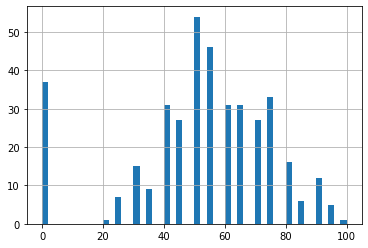

In [87]:
#score
df['score'].hist(bins=50)
#2.3. Распределение симметричное, унимодальное
#2.4. Расчетных выбросов найдено не было (bottom_outliers = 0, top_outliers = 0), однако внимание обращает разрыв (gaps)
#в самом начале распределения, после которого следуют нулевые быллы за экзамен у 37 студентов (9% выборки), так как
# у 6 студентов отсутстввие данных отмечено значением (NaN), возможно это студенты которые сдавали экзамен, но даже
#не приступили к работе.
#2.5. Так как количество баллов (score), это основной показатель анализа, отфильтруем значения NaN.
df = df[df['score'].isnull()==False]

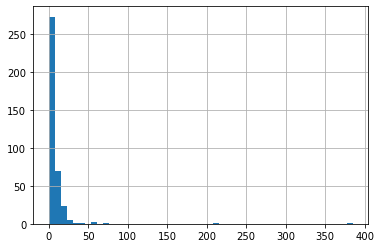

In [88]:
#absences
df['absences'].hist(bins=50)
#2.1.Распределение имеет очень ярко выраженный пик, от 0 до 10 пропусков 270 студентов (70% выборки).
#2.3.Распределение унимодальное немного смещенное вправо.
#2.4.Отфильтруем выбросы по верхней границе.
df=df[df['absences']<description.loc['top_bound', 'absences']]

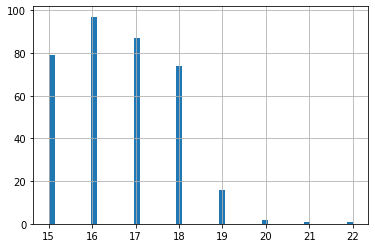

In [89]:
#age
df['age'].hist(bins=50)
#2.3.Распределение унимодальное немного смещенное вправо.
#2.4.Отфильтруем выбросы по верхней границе.
df=df[df['age']<description.loc['top_bound', 'age']]

In [90]:
#Зафиксируем показатели после очистки
df = DataFrame(df)
description = DataFrame(df[variable_types['quantitative']]).describe()
print(description)

                      score         age    absences
count            355.000000  355.000000  355.000000
mean              52.014085   16.597183    4.408451
std               23.090031    1.201925    4.714377
min                0.000000   15.000000    0.000000
25%               42.500000   16.000000    0.000000
50%               55.000000   17.000000    3.000000
75%               70.000000   18.000000    6.500000
max              100.000000   20.000000   19.000000
nan_count          0.000000    0.000000    0.000000
iqr               27.500000    2.000000    6.500000
bottom_bound       1.250000   13.000000   -9.750000
bottom_outliers   36.000000    0.000000    0.000000
top_bound        111.250000   21.000000   16.250000
top_outliers       0.000000    0.000000    7.000000
mode              50.000000   16.000000    0.000000


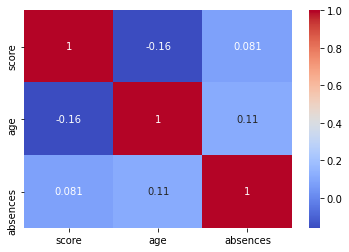

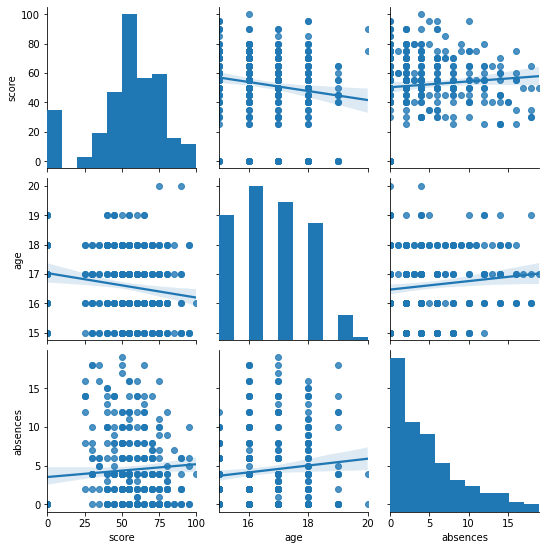

In [91]:
#5-6. Корреляционный анализ
sns.heatmap(df[variable_types['quantitative']].corr(),annot=True,cmap='coolwarm')
sns.pairplot(df[variable_types['quantitative']],kind='reg',)

#Числовые показатели  слабо корелируют между собой.

In [92]:
#7.Поиск статистически значимых различий
statistically_significant = set()
for x in variable_types['nominative']:
    if df.get_stat_dif(x,'score',0.05,10):
        statistically_significant.add(x)

columns = statistically_significant.union(variable_types['quantitative'])

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [93]:
df = df.loc[:,columns]
df.head(10)


,higher,score,romantic,paid,failures,age,mjob,sex,absences,address,medu
0,yes,30.0,no,no,0.0,18,at_home,F,6.0,U,4.0
1,yes,30.0,no,no,0.0,17,at_home,F,4.0,U,1.0
2,yes,50.0,NaN,NaN,3.0,15,at_home,F,10.0,U,1.0
3,yes,75.0,yes,yes,0.0,15,health,F,2.0,U,4.0
4,yes,50.0,no,yes,0.0,16,other,F,4.0,U,3.0
5,yes,75.0,no,yes,0.0,16,services,M,10.0,U,4.0
6,yes,55.0,no,no,0.0,16,other,M,0.0,NaN,2.0
7,yes,30.0,no,no,0.0,17,other,F,6.0,U,4.0
8,yes,95.0,no,yes,0.0,15,services,M,0.0,U,3.0
9,yes,75.0,no,yes,0.0,15,other,M,0.0,U,3.0


In [94]:
#Выводы:
#-Найдены выбросы в столбце с количеством пропусков.
#-Сильной корреляции между количественными переменными обнаружено не было.
#-Статистически значимые различия обнаружены по столбцам
#'higher', 'romantic', 'paid', 'failures', 'mjob', 'sex', 'address', 'medu'


